# Demo of SCOD on MNIST

In [2]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import matplotlib
import numpy as np
from tqdm import trange

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import Subset
from matplotlib import pyplot as plt

In [3]:
mnist = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
dataset = Subset(mnist, np.random.choice(len(mnist), 5000))

/home/apoorva/code/scod_module/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# DNN mapping 2d input to 1d distribution parameter
model = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 10)
    )

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Categorical(logits=theta)

prior_weight_var = 1e3

  0%|          | 0/20 [00:00<?, ?it/s]/home/apoorva/code/scod_module/venv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
mean_loss=0.289445: 100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


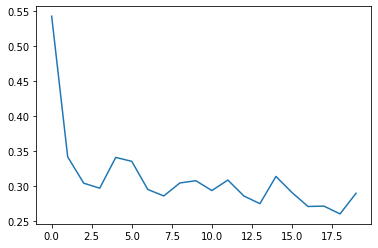

In [5]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
t = trange(20)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / prior_weight_var

        total_loss = mean_loss + regularization

        total_loss.backward()

        epoch_loss += total_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [6]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304
})

In [7]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


100%|██████████| 5000/5000 [00:58<00:00, 85.49it/s]


In [8]:
val_dataset =  MNIST(root="~/data/",train=False,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
ood_dataset = FashionMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

In [9]:
unc_model.eps = 1e3

In [12]:
unc_model.calibrate(Subset(val_dataset, np.random.choice(len(val_dataset), 500)),0.9)

100%|██████████| 50/50 [00:08<00:00,  6.13it/s]


In [65]:
## DEFINE VISUALIZATION FUNCTIONS
def plt_image(ax, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = 0.1307
    std = 0.3081
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp[:,:,0], cmap='Greys')

def viz_dataset_sample(ax, dataset, idx=0, model=None, unc_model=None):
    input, target = dataset[idx]
    plt_image(ax, input)
    xlabel = 'Target: %d' % target
    if unc_model is not None:
        pred, unc = unc_model(input.unsqueeze(0))
        pred = np.argmax(pred[0].detach().cpu().numpy())
        unc = unc.item()
        xlabel += '\nPred: %d\nUnc: %0.3f' % (pred, unc)
    elif model is not None:
        pred = np.argmax( model(input.unsqueeze(0))[0].detach().cpu().numpy() )
        xlabel += '\nPred: %d' % pred
    ax.set_xlabel(xlabel)

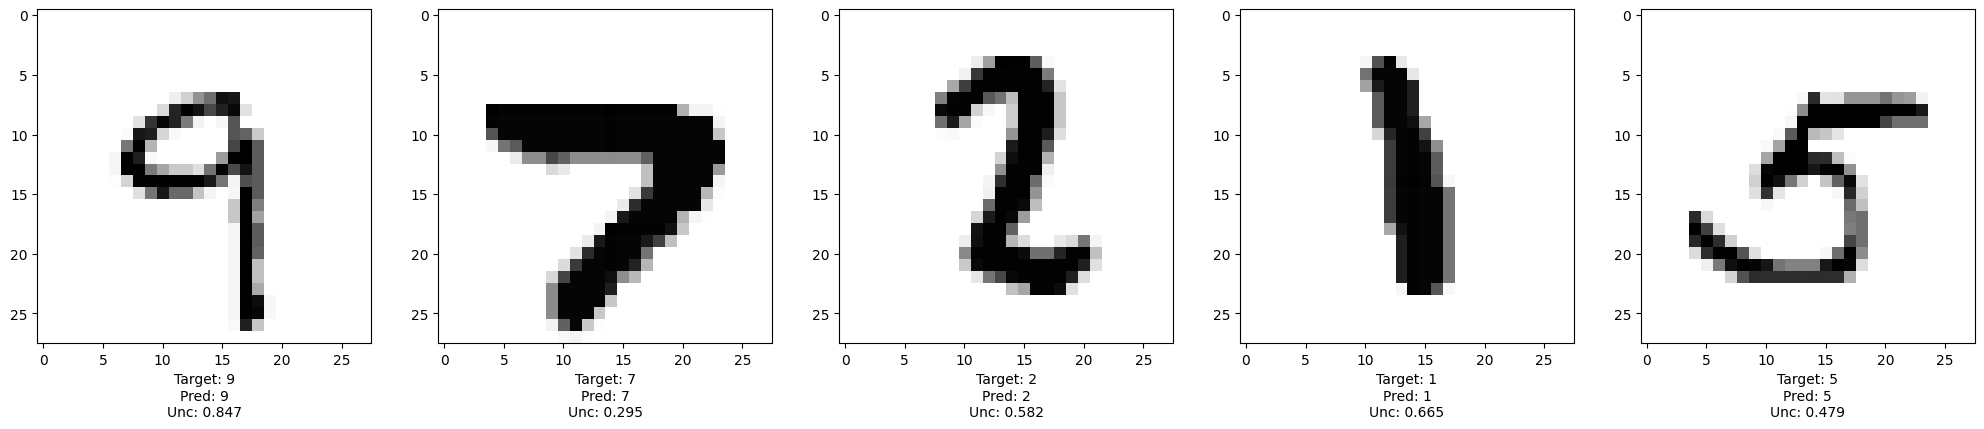

In [66]:
num_plots = 5
fig, axes = plt.subplots(1,num_plots, figsize=[5*num_plots, 5], dpi=100)
for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
    viz_dataset_sample( axes[j], dataset, idx, unc_model=unc_model )

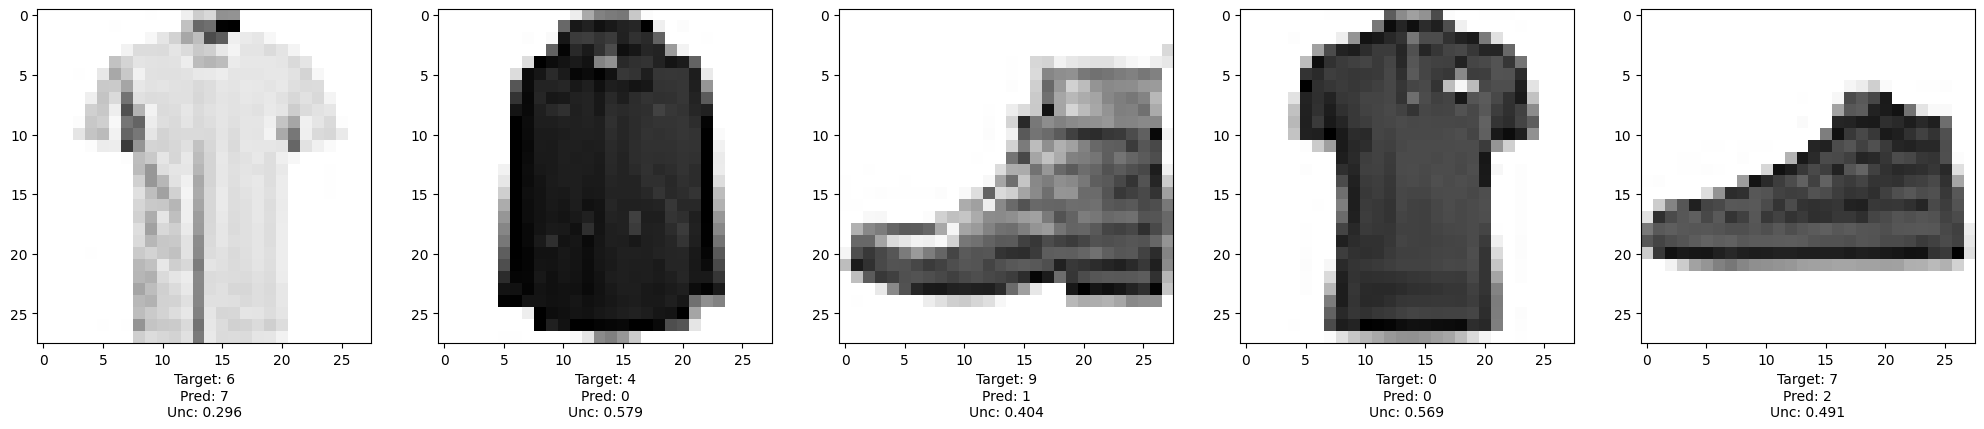

In [67]:
num_plots = 5
fig, axes = plt.subplots(1,num_plots, figsize=[5*num_plots, 5], dpi=100)
for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
    viz_dataset_sample( axes[j], ood_dataset, idx, unc_model=unc_model )

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm
val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), 500))
ood_subset = Subset(ood_dataset, np.random.choice(len(ood_dataset), 500))

val_uncs = torch.cat( [ unc_model(batch[0])[1] for batch in tqdm(DataLoader(val_subset, batch_size=25, shuffle=False)) ] )
ood_uncs = torch.cat( [ unc_model(batch[0])[1] for batch in tqdm(DataLoader(ood_subset, batch_size=25, shuffle=False)) ] )

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


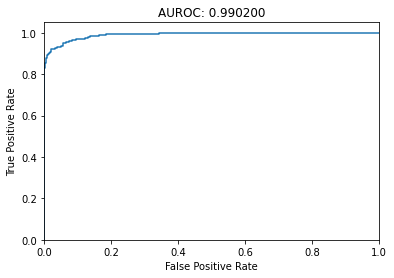

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresh = roc_curve(np.concatenate([np.zeros(500), np.ones(500)]), torch.cat([val_uncs, ood_uncs]).detach())

auroc = roc_auc_score(np.concatenate([np.zeros(500), np.ones(500)]), torch.cat([val_uncs, ood_uncs]).detach())
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUROC: %03f"%auroc)
plt.show()